 # Подготовка окружения

In [24]:
!pip install opendatasets

In [25]:
import opendatasets as od
import pandas as pd
import time
from pathlib import Path

## Скачиваем датасет
Потребуется kaggle ключ для доступа к данным (токен).  
Выглядит примерно так:
aleksandrivanov.
982a6e**********************45b2.

Получить можно в своём профиле:

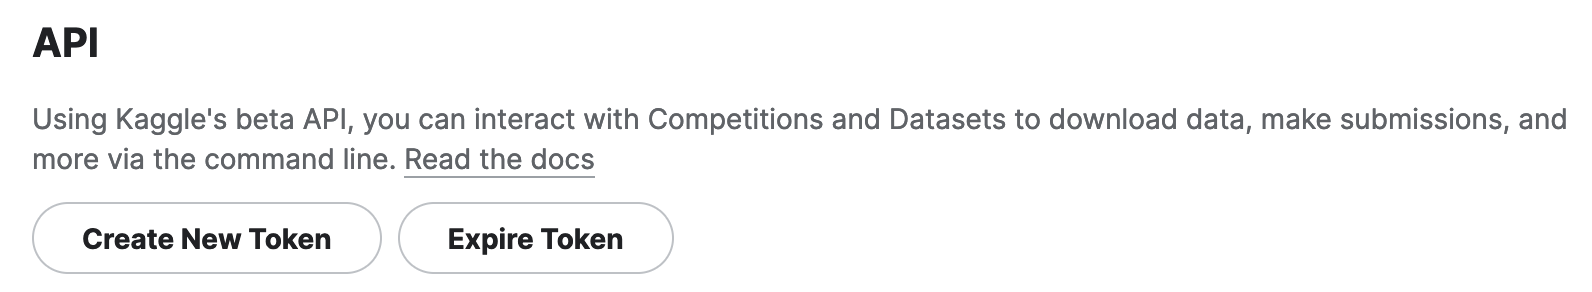

Файл подобран таким образом, чтобы был достаточно большим, чтобы не влезать в оперативную память, но достаточно мал, чтобы с ним можно было работать локально без кластера.

In [26]:
dataset_path = Path('imdb-user-reviews', 'song_lyrics.csv')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/sadmadlad/imdb-user-reviews')

Skipping, found downloaded files in "./imdb-user-reviews" (use force=True to force download)


# Интро к домашней работе
Повторение пройденного на семинаре

Например, у нас есть задача, нам нужно найти строку с самым большим количеством букв. Мы можем сделать это с помощью следующей фцнкции:

In [27]:
def find_longest_string(list_of_strings):
    longest_string = None
    longest_string_len = 0
    for s in list_of_strings:
        # отсавляем только буквы
        s = ''.join(x for x in s if x.isalpha())
        s_len = len(s)
        if s_len > longest_string_len:
            longest_string_len = s_len
            longest_string = s
    return longest_string, longest_string_len

Для малого количества строк малой длины всё считается быстро:

In [28]:
list_of_strings = ['abc123', 'python', 'sasha2000']
print(find_longest_string(list_of_strings))

('python', 6)


Но, если строк будет много, то время работы увеличивается на порядок (сложность растёт линейно). А чаще всего данных много ...

In [29]:
large_list_of_strings = list_of_strings * 1_000_000

In [30]:
%time print(find_longest_string(large_list_of_strings))

('python', 6)
CPU times: user 4.5 s, sys: 18.6 ms, total: 4.52 s
Wall time: 4.71 s


Как мы уже знаем, для того, чтобы код выполнялся быстрее, можно взят более мощный компьютер/процессор (vertical scaling), либо считать на нескольких компьютерах/процессорах/ядрах параллельно (horizontal scaling).  
Пример выше является идеально параллелизуемой задачей.
Подготовим данные для распараллеливания:
- разобъём список на партиции - на несколько списков;
- запустим так, чтобы каждая партиция считалась независимо.
- напишем reducer, которые будет собирать и аггрегировать результаты от каждой партиции.

In [31]:
from functools import reduce

def chunkify(list_of_strings, number_of_chunks=30):
    step = len(list_of_strings) // number_of_chunks
    if step != 0:
        for i in range(0, len(list_of_strings), step):
            yield list_of_strings[i : i + step]
    else:
        yield list_of_strings

def chunks_mapper(chunk):
    return find_longest_string(chunk)

def reducer(p, c):
    if p[1] > c[1]:
        return p
    return c

In [32]:
%%timeit
data_chunks = chunkify(large_list_of_strings, number_of_chunks=1)
# print(data_chunks)
#step 1:
mapped = map(chunks_mapper, data_chunks)
# print(mapped)
#step 2:
reduced = reduce(reducer, mapped)
print(reduced)

('python', 6)
('python', 6)
('python', 6)
('python', 6)
('python', 6)
('python', 6)
('python', 6)
('python', 6)
4.41 s ± 989 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Наши данные, в среднем, обсчитываются за 2.44 с.

In [33]:
from joblib import Parallel, delayed

In [34]:
%%timeit
data_chunks = chunkify(large_list_of_strings, number_of_chunks=2)
#step 1:
mapped = Parallel(n_jobs=2)(delayed(chunks_mapper)(chunk) for chunk in data_chunks)
#step 2:
reduced = reduce(reducer, mapped)

3.83 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


В два потока стало считать быстрее. Но из-за ограничений colab мы не можем полноценно воспрользоваться мультипоточностью, попробуйте на личном компьютере какой у вас будет прирост (у меня 1.29 против 1.74, а в 4 потока считается за 0.7 секунды)?

Теперь давайте нашу функцию find_longest_string переделаем так, чтобы каждая строчка считалась в отдельной функции mapper:

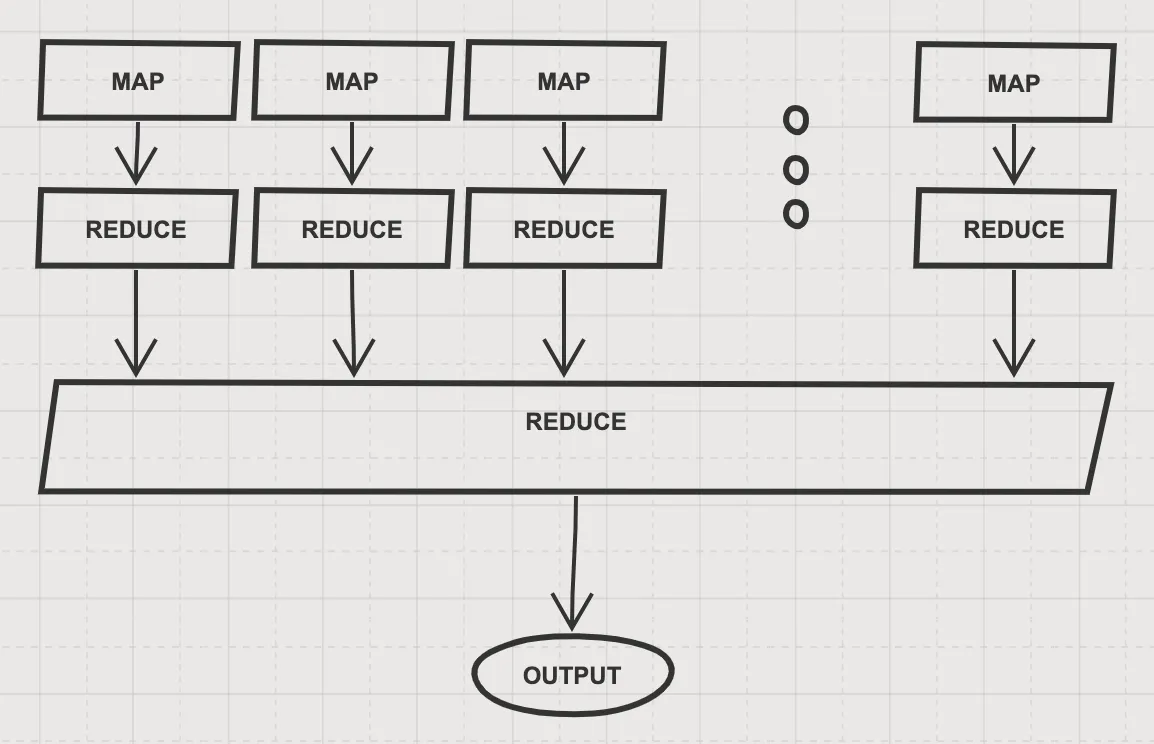

In [35]:
mapper = len

def chunks_mapper(chunk):
    mapped_chunk = map(mapper, chunk)
    mapped_chunk = zip(chunk, mapped_chunk)
    return reduce(reducer, mapped_chunk)

In [36]:
%%time
from functools import reduce

data_chunks = chunkify(large_list_of_strings, number_of_chunks=1)
#step 1:
mapped = map(chunks_mapper, data_chunks)
#step 2:
reduced = reduce(reducer, mapped)
print(reduced)

('sasha2000', 9)
CPU times: user 509 ms, sys: 3.79 ms, total: 513 ms
Wall time: 517 ms


И этот код так же легко параллелится:

In [37]:
%%time
from multiprocessing import Pool

data_chunks = chunkify(large_list_of_strings, number_of_chunks=2)
with Pool(2) as p:
    #step 1:
    mapped = p.map(chunks_mapper, data_chunks)
    #step 2:
    reduced = reduce(reducer, mapped)

CPU times: user 108 ms, sys: 57 ms, total: 165 ms
Wall time: 728 ms


In [38]:
%%time
# либо так
data_chunks = chunkify(large_list_of_strings, number_of_chunks=2)
#step 1:
mapped = Parallel(n_jobs=2)(delayed(chunks_mapper)(chunk) for chunk in data_chunks)

#step 2:
reduced = reduce(reducer, mapped)

CPU times: user 118 ms, sys: 4.04 ms, total: 122 ms
Wall time: 658 ms


Но готовые реализации языка чаще всего быстрее:

In [39]:
%time max_length = max(large_list_of_strings, key=len)

CPU times: user 92.2 ms, sys: 995 µs, total: 93.2 ms
Wall time: 93.1 ms


# Домашняя работа

Сделайте mapper и reducer, чтобы посчитать среднее и дисперсию оценок за фильм.

Реализация через цикл (предпогаем, что мы не знаем сколько у нас фильмов):

In [138]:
import json


n, mean, M2 = 0, 0.0, 0
for path in Path('imdb-user-reviews').glob('**/*'):
    if path.is_file() and path.suffix == '.json':
        with open(path, 'r') as f:
            info = json.load(f)
        score = float(info['movieIMDbRating'])
        n += 1
        delta = score - mean
        mean += delta / n
        M2 += delta * (score - mean)
        # print(score, n, delta, M2)

print(mean, (M2 / n) ** (1/2))

8.03 1.0517128885774862


На основе этого кода соберите mapper и reducer:

In [136]:
def mapper(path):
    if path.is_file() and path.suffix == '.json':
        with open(path, 'r') as f:
          info = json.load(f)
          score = float(info['movieIMDbRating'])
        return (score, )

In [125]:
def reducer(score_data1, score_data2):
    if score_data1 is None and score_data2 is None:
      return None
    elif score_data1 is None:
      return score_data2
    elif score_data2 is None:
      return score_data1
    else:
      scores = []
      if len(score_data1) == 1:
        n, mean, М2 = 0, 0.0, 0
        scores.append(score_data1[0])
      else:
        n, mean, М2 = score_data1
        scores.append(score_data2[0])
      for score in scores:
        n += 1
        delta = score - mean
        mean += delta / n
        М2 += delta * (score - mean)

    return n, mean, М2

In [141]:
%%time
# print(list(map(mapper, Path('imdb-user-reviews').glob('**/*'))))
n, mean, M2 = reduce(reducer, map(mapper, Path('imdb-user-reviews').glob('**/*')))
# print(n, mean, M2)
print(mean, (M2 / n) ** (1/2))

8.033333333333333 1.1085526098877263
CPU times: user 4.26 ms, sys: 0 ns, total: 4.26 ms
Wall time: 4.54 ms
